Run Palantir and MAGIC (ABpxp)
---
Run [Palantir](https://www.nature.com/articles/s41587-019-0068-4) to get a pseudotime, and [MAGIC](https://doi.org/10.1016/j.cell.2018.05.061) to get imputed gene expression, useful for visualizing gene expression trends. Note: we only use imputed gene expression to visualize gene expression trends, and nowhere else. 

# Preliminaries

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# single cell packages
import scanpy as sc

# rest
import numpy as np
import pandas as pd
import scvelo as scv
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt

## Dependencies

This notebook depends on [ML_2023-03-31_moslin_abpxp.ipynb](ML_2023-03-31_moslin_abpxp.ipynb). 

## Define utility functions

## Set up paths

Define the paths to load data, cache results and write figure panels.

In [3]:
sys.path.insert(0, "../../")  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, FIG_DIR

FIG_DIR = FIG_DIR / "packer_c_elegans"
DATA_DIR = DATA_DIR / "packer_c_elegans"

Set up the paths to save figures.

In [4]:
sc.settings.figdir = str(FIG_DIR)

## Set global parameters

In [5]:
# number of neighbors
knn=30

# number of waypoings samples
num_waypoints=1200

# parallelisation
n_jobs=-1

# scaling
scale_components=True

# whether to write Palantir's pseudotime and MAGIC imputed data
write_data = True

# whether to recompute Palantir's waypoint cells
write_waypoints = False
recompute_waypoints = False

In [6]:
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=25, color_map='viridis')
scv.settings.plot_prefix = ""

## Import the data

Import the AnnData object. This is normalized and log-transformed data. 

In [7]:
adata = sc.read(DATA_DIR / "ML_2023-03-31_c_elegans_abpxp_adata.h5ad")
adata

AnnData object with n_obs × n_vars = 6476 × 20222
    obs: 'idx', 'barcode', 'n.umi', 'time.point', 'batch', 'Size_Factor', 'cell.type', 'cell.subtype', 'plot.cell.type', 'raw.embryo.time', 'embryo.time', 'embryo.time.bin', 'raw.embryo.time.bin', 'lineage', 'passed_initial_QC_or_later_whitelisted', 'random_precise_lineage', 'clusters', 'coarse_clusters', 'assigned_batch_time', 'marginals', 'time', 'time_point'
    var: 'Ensembl', 'gene_short_name', 'Symbol', 'Family', 'Protein', 'Entrez_ID', 'TF', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'coarse_clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'raw.embryo.time_colors', 'time_point_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

Check the matplotlib backend. 

In [8]:
mpl.rcParams["backend"]

'module://matplotlib_inline.backend_inline'

# Prepare for running Palantir

In [9]:
import palantir
print(f"palantir=={palantir.__version__}")

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


palantir==1.1


Palantir changes the plotting backend: 

In [10]:
mpl.rcParams["backend"]

'agg'

Let's change it back: 

In [11]:
mpl.use("module://matplotlib_inline.backend_inline")
mpl.rcParams["backend"]

'module://matplotlib_inline.backend_inline'

## Compute PCA, Diffmap and Multiscale data

Compute PCA representation and Diffmap

In [12]:
sc.pp.pca(adata, use_highly_variable=True, n_comps=500) # need to recompute this to have enough components
n_comps = np.where(np.cumsum(adata.uns['pca']['variance_ratio']) > 0.85)[0][0]
print(f"This selects {n_comps} PCs. ")
dm_res = palantir.utils.run_diffusion_maps(pd.DataFrame(adata.obsm['X_pca'][:, :n_comps], 
                                                        index=adata.obs_names), n_components=20)

This selects 325 PCs. 
Determing nearest neighbor graph...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Use the diffusion components to construct a denoised KNN graph and data representation:

In [13]:
# comptue multiscale space in diffusion map space
ms_data = palantir.utils.determine_multiscale_space(dm_res, n_eigs=15)
ms_data.shape

(6476, 14)

## Visualise multiscale data

Visualise multiscale components in the UMAP

findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: 

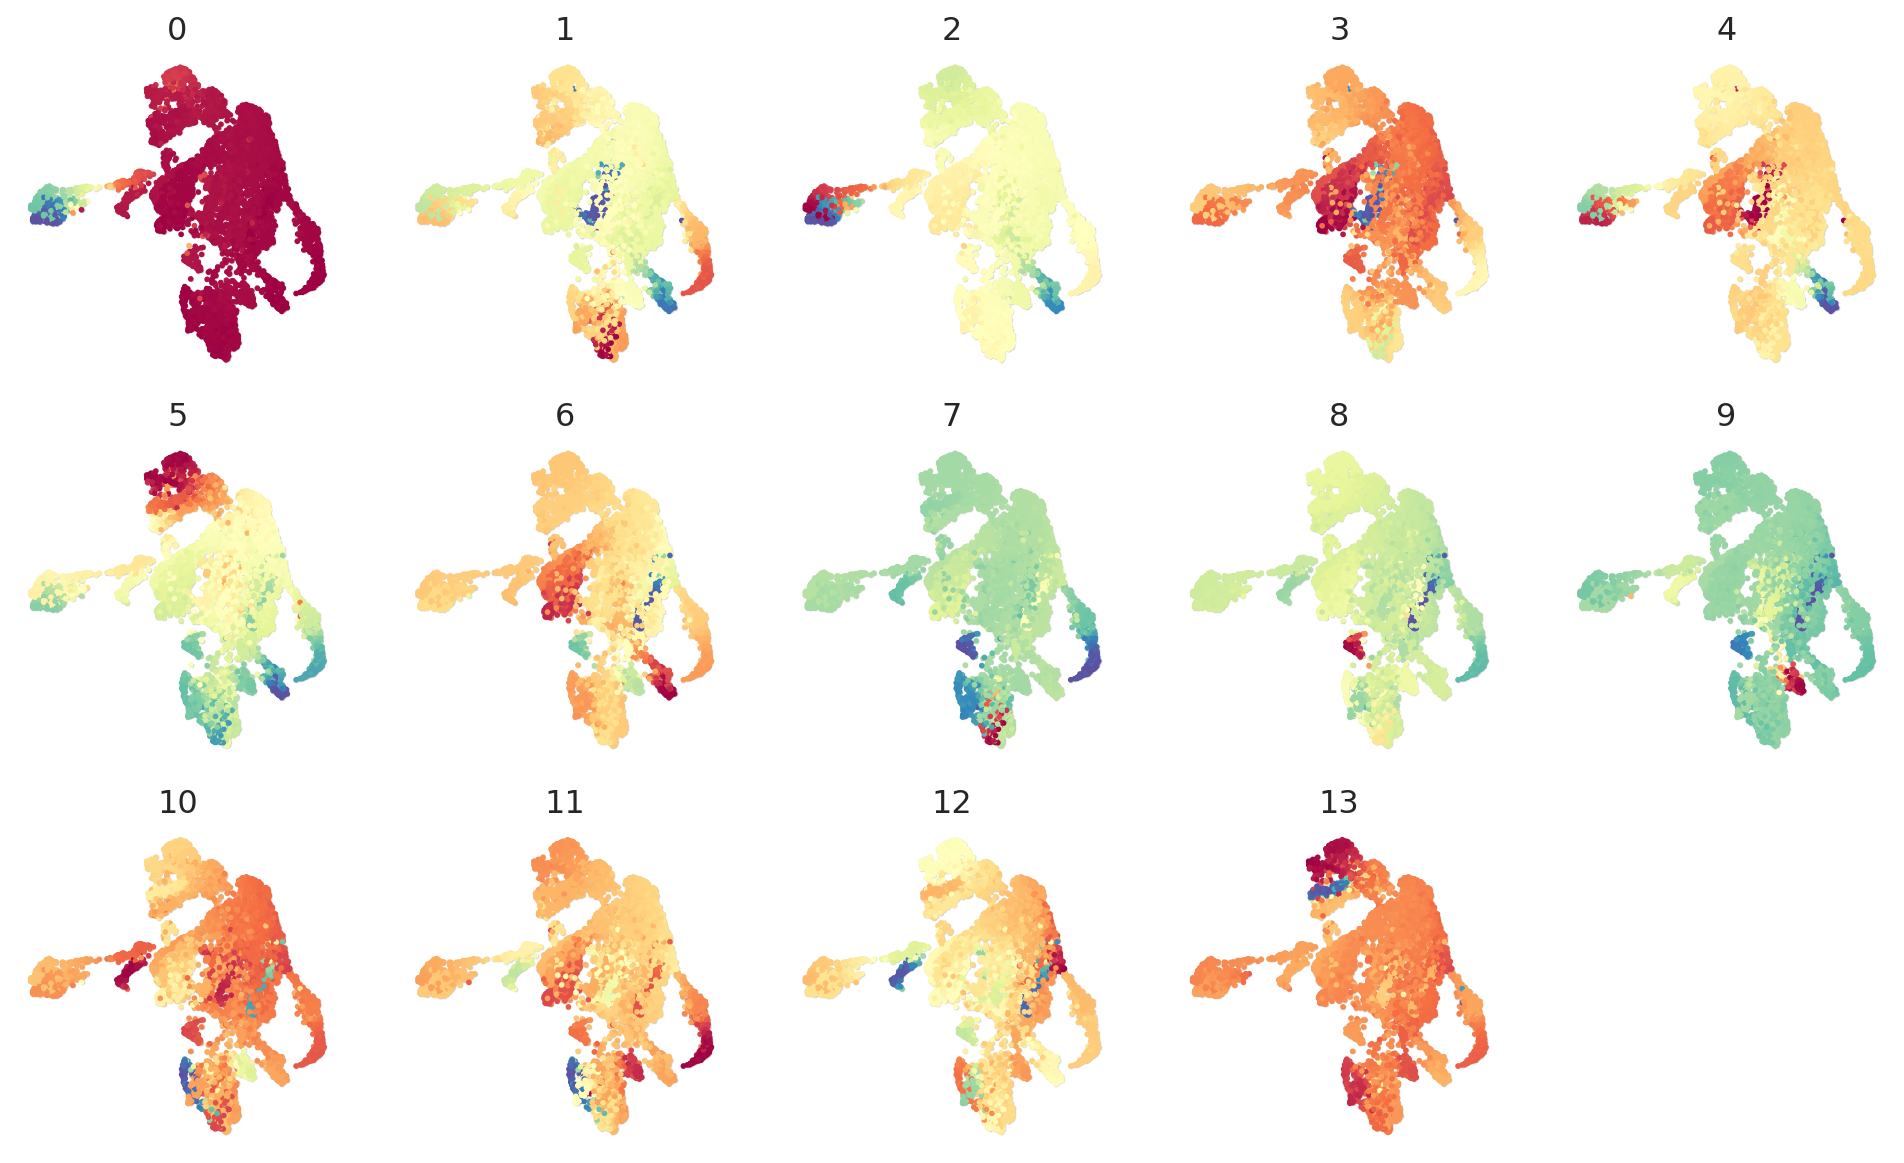

In [14]:
umap = pd.DataFrame(adata.obsm['X_umap'], index=adata.obs_names, columns=['x', 'y'])
palantir.plot.plot_gene_expression(ms_data, umap, ms_data.columns)

## Define an initial cell

Let's choose a random early cell:

In [15]:
adata.obs.loc[adata.obs['raw.embryo.time'] == 120]

,idx,barcode,n.umi,time.point,batch,Size_Factor,cell.type,cell.subtype,plot.cell.type,raw.embryo.time,...,raw.embryo.time.bin,lineage,passed_initial_QC_or_later_whitelisted,random_precise_lineage,clusters,coarse_clusters,assigned_batch_time,marginals,time,time_point
cell,,,,,,,,,,,,,,,,,,,,,
AGCTCCTCAAGCCCAC-r17,61078,AGCTCCTCAAGCCCAC-r17,4688,mixed,0,2.944667,NaN,NaN,NaN,120,...,100-130,ABpxppa,True,ABplppa,Progenitor cell,Progenitor cell,170,0.014523,170.0,170
AGCTCTCAGCGGCTTC-r17,61088,AGCTCTCAGCGGCTTC-r17,5625,mixed,0,3.520920,NaN,NaN,NaN,120,...,100-130,ABpxpap,True,ABprpap,Progenitor cell,Progenitor cell,170,0.004030,170.0,170
CATCAAGCATCTGGTA-r17,62469,CATCAAGCATCTGGTA-r17,9265,mixed,0,5.830955,NaN,NaN,NaN,120,...,100-130,ABpxppp,True,ABprppp,Progenitor cell,Progenitor cell,170,0.008185,170.0,170
CGTTCTGGTCTCTCGT-r17,63784,CGTTCTGGTCTCTCGT-r17,9321,mixed,0,5.851042,NaN,NaN,NaN,120,...,100-130,ABpxppp,True,ABprppp,Progenitor cell,Progenitor cell,170,0.011315,170.0,170
CTCATTATCCCTTGTG-r17,64019,CTCATTATCCCTTGTG-r17,7696,mixed,0,4.844169,NaN,NaN,NaN,120,...,100-130,ABpxppa,True,ABprppa,Progenitor cell,Progenitor cell,170,0.016604,170.0,170
TTATGCTAGAGCTATA-r17,68266,TTATGCTAGAGCTATA-r17,8799,mixed,0,5.511442,NaN,NaN,NaN,120,...,100-130,ABpxppa,True,ABplppa,Progenitor cell,Progenitor cell,170,0.014523,170.0,170


(<Figure size 320x320 with 1 Axes>, <Axes: >)

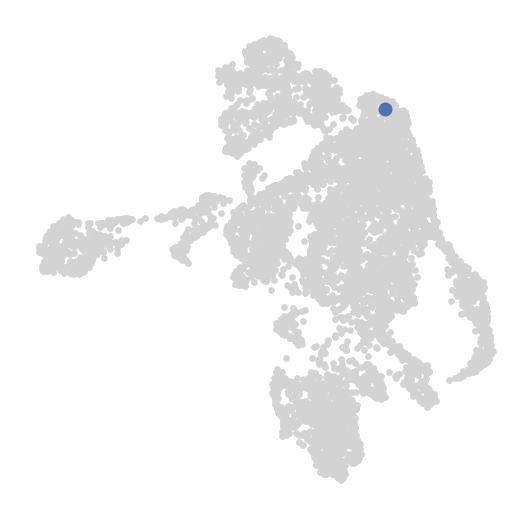

In [16]:
# root_cell = ms_data[18].idxmax()
root_cell = "AGCTCCTCAAGCCCAC-r17"
palantir.plot.highlight_cells_on_tsne(umap, root_cell)

# Run Palantir

## Compute a pseudotime 

Note: Palantir is not exactly reproducible if you don't save the waypoint cells. 

In [17]:
import random
random.seed = 0
np.random.seed(0)

if not recompute_waypoints:
    print("Loading waypoint cells from file")
    waypoints = pd.Index(pd.read_csv(DATA_DIR / "palantir" / "ML_2023-03-30_waypoints.csv", index_col=0)["0"]) 

pr_res = palantir.core.run_palantir(ms_data,
                                    root_cell, 
                                    terminal_states=None,
                                    knn=knn, 
                                    num_waypoints=num_waypoints if recompute_waypoints else waypoints, 
                                    n_jobs=n_jobs,
                                    scale_components=scale_components,
                                    use_early_cell_as_start=True)

if write_waypoints:
    print("Writing waypoint cells to file")
    pd.Series(pr_res.waypoints).to_csv(DATA_DIR / "palantir" / "waypoints.csv")

Loading waypoint cells from file
Sampling and flocking waypoints...
Time for determining waypoints: 1.4746189117431641e-05 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...


findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling bac

Time for shortest paths: 0.0939345677693685 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9993
Correlation at iteration 2: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: 

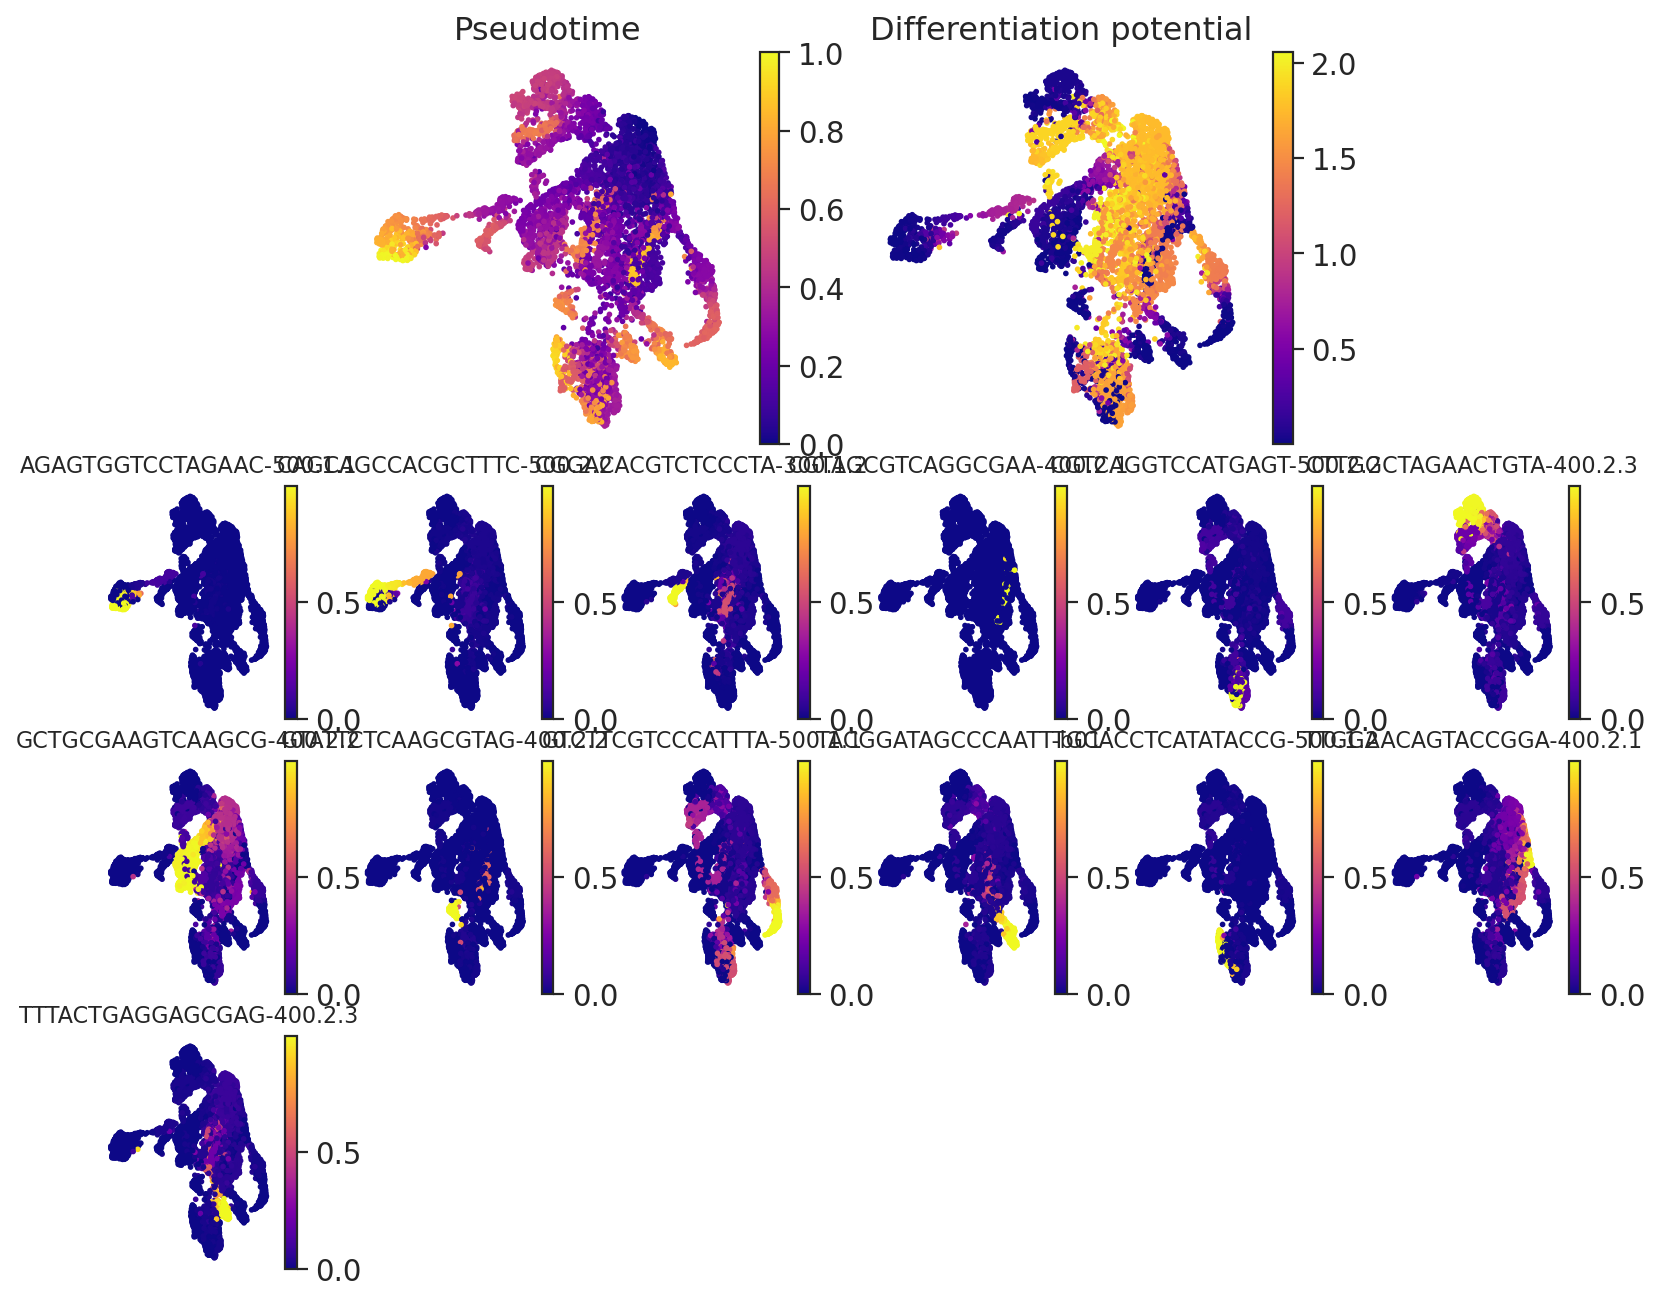

In [18]:
palantir.plot.plot_palantir_results(pr_res, umap)

## Run MAGIC

findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: 

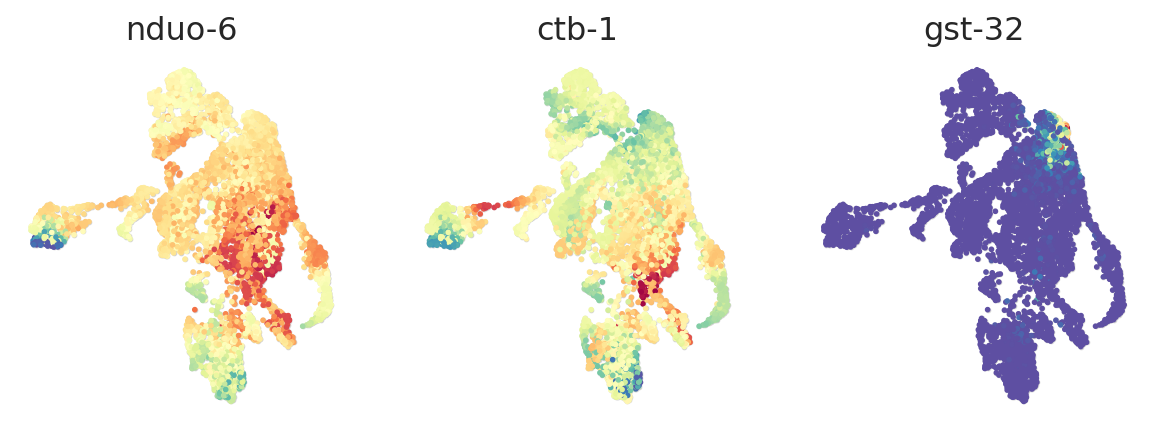

In [19]:
imp_df = palantir.utils.run_magic_imputation(adata, dm_res)
palantir.plot.plot_gene_expression(imp_df, umap, ['nduo-6', 'ctb-1', 'gst-32'])

## Write to AnnData

Actually to the writing. 

In [20]:
# save the pseudotime
adata.obs['palantir_pseudotime'] = pr_res.pseudotime.copy()

# save the imputed data
adata.layers['magic_imputed_data'] = imp_df.values

## Write to file

In [21]:
if write_data:
    print("Writing data to file")
    palantir_pseudotime = sc.get.obs_df(adata, keys=["palantir_pseudotime"])
    magic_imputed_data = pd.DataFrame(data=adata.layers['magic_imputed_data'], 
                                      index=adata.obs_names, columns=adata.var_names)
    palantir_pseudotime.to_csv(DATA_DIR / "palantir" / "ML_2023-04-01_palantir_pseudotime.csv")
    magic_imputed_data.to_csv(DATA_DIR / "palantir" / "ML_2023-04-01_magic_imputed_data.csv")

Writing data to file
